<a href="https://colab.research.google.com/github/Accenture-AI-Studio/fake-news/blob/main/Cleaned_Dataset_%2B_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Dataset

In [ ]:
# install and import libraries

!pip install rapidfuzz
!pip install datasketch
!pip install nltk

import pandas as pd
import numpy as np
import re
import os
import pickle
import nltk
from nltk.corpus import stopwords
from datasketch import MinHash, MinHashLSH
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

from google.colab import drive, files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
# load datasets 'True.csv' and 'Fake.csv' from google drive and concat them into a single dataframe 'df'

drive.mount('/content/drive')
for f in os.listdir():
    print(f)

df_false = pd.read_csv('/content/drive/MyDrive/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/True.csv')

df_false["label"] = 0
df_true["label"] = 1

df = pd.concat([df_true, df_false], axis=0).reset_index(drop=True)

Mounted at /content/drive
.config
drive
sample_data


## Analyze & Clean Data

In [ ]:
# analyze dataframe

print(df.shape)
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

(44898, 5)
📰 True articles:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   
5  White House, Congress prepare for talks on spe...   
6  Trump says Russia probe will be fair, but time...   
7  Factbox: Trump on Twitter (Dec 29) - Approval ...   
8         Trump on Twitter (Dec 28) - Global Warming   
9  Alabama official to certify Senator-elect Jone...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SE

In [ ]:
# check rows for any missing values

print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [title, text, subject, date, label]
Index: []


In [ ]:
# print the unique values & their counts for column 'subject'

subject_label_counts = df.groupby(['subject', 'label']).size()
print(subject_label_counts)

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
politicsNews     1        11272
worldnews        1        10145
dtype: int64


In [ ]:
# drop 'left-news' in Fake column as it doesn't have an equivalent in True columns and could learn bias

df = df[df['subject'] != 'left-news']
print(df['subject'].value_counts())

# drop 'subject' and 'date' columns as they don't carry significant information

df = df.drop(columns=['subject', 'date'])
print(df.columns.tolist())

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64
['title', 'text', 'label']


In [ ]:
# convert text in columns 'text' and 'title' to lowercase

df['text'] = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [ ]:
# find word count metrics for text and title based on label

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())


         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      19022.0  430.338503  417.925202  0.0  257.0  371.0  505.0  8135.0
1      21417.0  385.640099  274.006204  0.0  148.0  359.0  525.0  5172.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      19022.0  14.190727  3.975359  1.0  12.0  14.0  16.0  42.0
1      21417.0   9.954475  1.700747  4.0   9.0  10.0  11.0  20.0


In [ ]:
# remove any articles that only contain whitespaces
df = df[df['text'].str.strip() != '']
df = df[df['title'].str.strip() != '']

In [ ]:
# remove outlier articles (based on word count)

# obtain q1 and q3 text lengths
q1_text = df['text_length'].quantile(0.25)
q3_text = df['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text

q1_title = df['title_length'].quantile(0.25)
q3_title = df['title_length'].quantile(0.75)
iqr_title = q3_title - q1_title

# keep only articles within 1.5*IQR from q1 and q3
df = df[(df['text_length'] >= q1_text - 1.5*iqr_text) & (df['text_length'] <= q3_text + 1.5*iqr_text)]
df = df[(df['title_length'] >= q1_title - 1.5*iqr_title) & (df['title_length'] <= q3_title + 1.5*iqr_title)]

# remove any articles with less than 50 words in text
df = df[(df['text_length'] >= 50)]

In [ ]:
# analyze change

print(df.groupby('label')['text_length'].describe())
print(df.groupby('label')['title_length'].describe())

         count        mean         std   min    25%    50%    75%    max
label                                                                   
0      15936.0  396.744603  172.155638  50.0  292.0  377.0  493.0  969.0
1      20426.0  366.006854  232.142314  50.0  153.0  354.0  502.0  969.0
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      15936.0  13.619980  3.011208  4.0  12.0  14.0  16.0  21.0
1      20426.0   9.949917  1.690636  4.0   9.0  10.0  11.0  20.0


In [ ]:
# download stopwords from library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# clean text function
def full_clean_text(text):
    if not isinstance(text, str):
        return ""

    # remove anything before "(Reuters) - "
    text = re.sub(r"^.*?(?:\(Reuters\)|Reuters)\s*-\s*", "", text, flags=re.IGNORECASE)

    # fix encoding artifacts
    try:
        text = text.encode('latin1').decode('utf-8')
    except:
        pass

    # remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # remove month names and numbers
    text = re.sub(
    r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec|'
    r'january|february|march|april|may|june|july|august|september|october|november|december)\b\.?',
    '',
    text,
    flags=re.IGNORECASE
    )
    text = re.sub(r'\d+', '', text)


    # remove stopwords
    words = text.split()
    words = [w for w in words if w.lower() not in stop_words]
    text = " ".join(words)

    # remove weird symbols
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)

    # get rid of multiple whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# apply to both text and title
df['text'] = df['text'].apply(full_clean_text)
df['title'] = df['title'].apply(full_clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# print column count prior to duplicate and near duplicate removal
print(df.shape)

# remove duplicates
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)


# break text into shingles

shingle_size = 7                    # num of words per shingle
num_perm = 256                      # num of permutations for MinHash
similarity_threshold = 0.85         # MinHash similarity threshold for near-duplicates

def get_shingles(text, k=shingle_size):
    words = text.split()
    shingles = set()
    for i in range(max(len(words) - k + 1, 1)):
        shingles.add(" ".join(words[i:i+k]))
    return shingles


# remove near duplicates
def remove_near_duplicates(df, text_column="text"):
    lsh = MinHashLSH(threshold=similarity_threshold, num_perm=num_perm)
    minhashes = {}
    for idx, text in enumerate(df[text_column]):
        shingles = get_shingles(text)
        m = MinHash(num_perm=num_perm)
        for shingle in shingles:
            m.update(shingle.encode('utf8'))
        minhashes[idx] = m
        lsh.insert(idx, m)
    to_drop = set()
    for idx, m in minhashes.items():
        if idx in to_drop:
            continue
        result = lsh.query(m)
        for j in result:
            if j != idx:
                to_drop.add(j)
    df_cleaned = df.drop(list(to_drop)).reset_index(drop=True)
    return df_cleaned


# update df to clean ver
df = remove_near_duplicates(df, text_column="text")


# print column count after duplicate and near duplicate cleaning
print(df.shape)

(36362, 5)
(34751, 5)


In [ ]:
# Count how many articles are true and fake
print(df['label'].value_counts())

label
1    20184
0    14567
Name: count, dtype: int64


In [ ]:
# print current state of dataset
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

print("\n🧾 False articles:")
print(df[df["label"] == 0].head(10))

📰 True articles:
                                               title  \
0  u.s. budget fight looms, republicans flip fisc...   
1  u.s. military accept transgender recruits mond...   
2  senior u.s. republican senator 'let mr. muelle...   
3  fbi russia probe helped australian diplomat ti...   
4  trump wants postal service charge 'much more' ...   
5  white house, congress prepare talks spending, ...   
6  trump says russia probe fair, timeline unclear...   
7    factbox trump twitter - approval rating, amazon   
8                     trump twitter - global warming   
9  alabama official certify senator-elect jones t...   

                                                text  label  text_length  \
0  head conservative republican faction u.s. cong...      1          749   
1  transgender people allowed first time enlist u...      1          624   
2  special counsel investigation links russia pre...      1          457   
3  trump campaign adviser george papadopoulos tol...      1   

In [ ]:
# combine text and title columns into one
df['title_and_text'] = " [TITLE] " + df['title'] + " [ARTICLE] " + df['text']

X = df['title_and_text']
y = df['label']

# drop all other columns besides 'title_and_text' and 'label'
df.drop(columns = ['title', 'text', 'text_length', 'title_length'], inplace=True)


In [ ]:
# download clean dataset as csv file

from google.colab import files
df.to_csv('cleaned_articles.csv', index=False)
files.download('cleaned_articles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("📰 True articles:")
print(df[df["label"] == 1].head(10))

📰 True articles:
   label                                     title_and_text
0      1   [TITLE] u.s. budget fight looms, republicans ...
1      1   [TITLE] u.s. military accept transgender recr...
2      1   [TITLE] senior u.s. republican senator 'let m...
3      1   [TITLE] fbi russia probe helped australian di...
4      1   [TITLE] trump wants postal service charge 'mu...
5      1   [TITLE] white house, congress prepare talks s...
6      1   [TITLE] trump says russia probe fair, timelin...
7      1   [TITLE] factbox trump twitter - approval rati...
8      1   [TITLE] trump twitter - global warming [ARTIC...
9      1   [TITLE] alabama official certify senator-elec...


In [ ]:
df[df["label"] == 0].head(1)

,label,title_and_text
20184,0,[TITLE] donald trump sends embarrassing new y...


## TRAINING DATA

In [ ]:
# declare X and y
X = df['title_and_text']
y = df['label']

# convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)
X_tfidf = vectorizer.fit_transform(X)

# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=123)

# train model

clf = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', C=0.1)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

Accuracy: 0.9757
F1 Score: 0.9788
ROC AUC: 0.9971


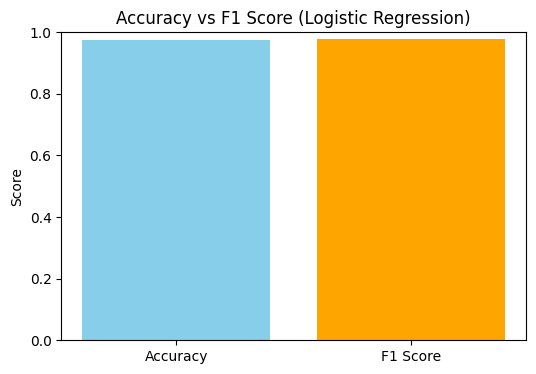

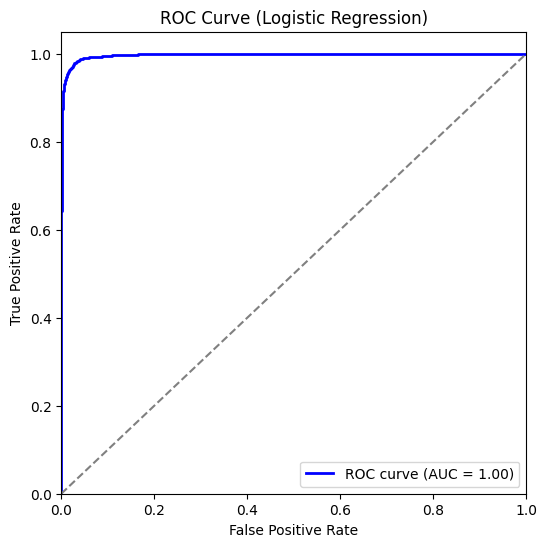

In [ ]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# compute metrics

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# visualize accuracy v. f1

plt.figure(figsize=(6,4))
plt.bar(['Accuracy', 'F1 Score'], [accuracy, f1], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.title("Accuracy vs F1 Score (Logistic Regression)")
plt.ylabel("Score")
plt.show()

# visualize roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# save model and vectorizer to google drive

model_dir = "/content/drive/MyDrive/my_lr_model"
os.makedirs(model_dir, exist_ok=True)

with open(os.path.join(model_dir, "logistic_regression.pkl"), "wb") as f:
    pickle.dump(clf, f)

with open(os.path.join(model_dir, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved succesfully.")

Model and vectorizer saved succesfully.


In [ ]:
# load model and vectorizer

with open(os.path.join(model_dir, "logistic_regression.pkl"), "rb") as f:
    loaded_clf = pickle.load(f)

with open(os.path.join(model_dir, "tfidf_vectorizer.pkl"), "rb") as f:
    loaded_vectorizer = pickle.load(f)